# AI Intent Evaluation with Prolific

This project demonstrates how to create and run human evaluation studies on Prolific to assess AI model performance in intent recognition tasks. The system automatically generates surveys, recruits participants, and collects human judgments on whether an AI correctly interpreted user messages.

## 🎯 Project Overview

The project consists of a Jupyter notebook (`DemoProlific.ipynb`) that:

1. **Takes a user message** and sends it an LLM model for intent interpretation
2. **Creates a survey** on Prolific asking human evaluators if the AI's interpretation was correct
3. **Recruits participants** based on specified criteria (age, country, etc.)
4. **Collects responses** and provides analysis tools
5. **Exports results** for further analysis


## Workflow

### 1. Setup and Authentication
- Import required libraries
- Load API keys from environment variables
- Authenticate and fetch your Prolific researcher ID

In [114]:
import json
import os
import uuid
import urllib.parse
from datetime import datetime
from io import StringIO

import pandas as pd
import requests
from dotenv import load_dotenv
import matplotlib.pyplot as plt

import openai
from openai import OpenAI

In [115]:
# Load environment variables 
load_dotenv()

client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))
prolific_token = os.getenv("PROLIFIC_API_TOKEN")

In [116]:
# Set up headers for authenticated requests to the Prolific API
headers = {
    "Authorization": f"Token {prolific_token}",
    "Content-Type": "application/json",
}

In [117]:
# Fetch your Prolific researcher ID
res = requests.get("https://api.prolific.com/api/v1/users/me/", headers=headers)
researcher_id = res.json()["id"]

### 2. Message Processing
- Define a user message to test
- Send it to an LLM for intent interpretation
- Extract the AI's response

In [118]:
user_message = "hope u dont go bald"

In [119]:
response = client.chat.completions.create(
    model="gpt-3.5-turbo",
    messages=[
        {"role": "system", "content": "Given a user message, respond what do you think is the intention behind the message in a short sentence."},
        {"role": "user", "content": user_message}
    ]
)

intent = response.choices[0].message.content.strip()

In [120]:
intent

'The intention behind the message seems to be expressing concern or humor about the recipient potentially losing their hair.'

### 3. Survey Creation
- Generate unique identifiers for survey components
- Build survey structure with the question: "Did the AI get the intent right?"
- Create the survey on Prolific's platform

In [121]:
# Build survey question
question_text = (
    f"If the user sent the message: \n'{user_message}'. \n\n"
    f"If the AI interpreted the intent as: \n"
    f"'{intent}' \n\n"
    "Do you think the AI got the intent right?"
)
print(question_text)

If the user sent the message: 
'hope u dont go bald'. 

If the AI interpreted the intent as: 
'The intention behind the message seems to be expressing concern or humor about the recipient potentially losing their hair.' 

Do you think the AI got the intent right?


In [122]:
# Generate UUIDs for question and answers
section_id = str(uuid.uuid4())
question_id = str(uuid.uuid4())
answer_yes_id = str(uuid.uuid4())
answer_no_id = str(uuid.uuid4())

In [123]:
# Build the payload
survey_data = {
    "researcher_id": researcher_id,
    "title": "Did the AI interpret the message correctly?",
    "sections": [
        {
            "id": section_id,
            "title": "Intent Evaluation",
            "questions": [
                {
                    "id": question_id,
                    "title": question_text,
                    "type": "single",
                    "answers": [
                        {"id": answer_yes_id, "value": "Yes"},
                        {"id": answer_no_id, "value": "No"},
                    ],
                }
            ],
        }
    ],
    "questions": [  # Flat list of questions (same structure)
        {
            "id": question_id,
            "title": question_text,
            "type": "single",
            "answers": [
                {"id": answer_yes_id, "value": "Yes"},
                {"id": answer_no_id, "value": "No"},
            ],
        }
    ],
}

In [124]:
response = requests.post(
    "https://api.prolific.com/api/v1/surveys/",
    headers=headers,  
    data=json.dumps(survey_data)
)

print(response.status_code)

201


In [125]:
survey_id = response.json()["_id"]

### 4. Study Configuration
- Set study parameters (configurable):
  - Reward: $0.50 per participant
  - Participants: 20 
  - Estimated time: 2 minutes
  - Age range: 18-28
  - Countries: US
- Generate completion codes and filters

In [144]:
study_config = {
    "reward": 1.50,
    "participants": 10,
    "estimated_time": 2,
    "max_time": 5,
    "age_range": "18-28",
    "countries": ["US"]
}

### 5. Study Publication
- Create the study with all parameters
- Publish it to make it available to participants
- Monitor study status and participant recruitment

In [145]:
completion_code = f"INTENT_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
estimated_time = int(study_config.get('estimated_time', 2))
max_time = int(study_config.get('max_time', 10))
reward_dollars = float(study_config.get('reward', 0.50))
reward_cents = int(reward_dollars * 100)
participants = int(study_config.get('participants', 10))
age_min, age_max = map(int, study_config.get('age_range', '18-25').split('-'))
countries = study_config.get('countries', ['US'])

prolific_country_choices = {'US': '1'}
prolific_country_ids = [prolific_country_choices[c] for c in countries if c in prolific_country_choices]

In [146]:
filters = [
    {"filter_id": "age", "selected_range": {"lower": age_min, "upper": age_max}}
]

if prolific_country_ids:
    filters.append({
        "filter_id": "current-country-of-residence",
        "selected_values": prolific_country_ids
    })

In [147]:
# Build the study payload for Prolific API
study_data = {
    "name": f"AI Intent Evaluation - {datetime.now().strftime('%Y-%m-%d %H:%M')}",
    "internal_name": f"AI Intent Study {datetime.now().strftime('%Y%m%d_%H%M%S')}",
    "description": "Evaluate whether an AI correctly identified the intent behind a user message",
    "external_study_url": f"https://prolific.com/surveys/{survey_id}",
    "completion_codes": [
        {
            "code": completion_code,
            "code_type": "COMPLETED",
            "actions": [{"action": "AUTOMATICALLY_APPROVE"}],
        }
    ],
    "estimated_completion_time": estimated_time,  # in minutes
    "maximum_allowed_time": max_time,  # in minutes
    "reward": reward_cents,  # in cents
    "total_available_places": participants,
    "device_compatibility": ["desktop"],
    "peripheral_requirements": [],
    "filters": filters,  # participant eligibility criteria
    "privacy_notice": (
        "Your data will be used for research purposes only and will be kept confidential."
    ),
}

In [148]:
# Create draft study
study_response = requests.post(
    "https://api.prolific.com/api/v1/studies/",
    headers=headers,
    data=json.dumps(study_data)
)

study_response.status_code

201

In [149]:
study_id = study_response.json().get("id")

In [150]:
# Publish study
publish_response = requests.post(
        f"https://api.prolific.com/api/v1/studies/{study_id}/transition/",
        headers=headers,
        data=json.dumps({"action": "PUBLISH"})
    )

In [151]:
publish_response.status_code

200

### 6. Data Collection and Analysis
- Monitor participant submissions
- Export results in CSV format
- Load data into pandas DataFrame for analysis
- Calculate completion times and response statistics

In [169]:
study_response = requests.get(
        f"https://api.prolific.com/api/v1/studies/{study_id}/",
        headers=headers)

In [170]:
study_info = study_response.json()
status = study_info.get("status")
name = study_info.get("name")
created_at = study_info.get("created_at")
total_places = study_info.get("total_available_places")
total_places_taken = study_info.get("places_taken")
created_at = datetime.fromisoformat(study_info.get("published_at").replace("Z", "+00:00")).strftime("%d %b %Y, %I:%M %p UTC")


print(f"✅ Study Name: {name}")
print(f"📊 Status: {status}")
print(f"👥 Total Places: {total_places}")
print(f"📩 Total Submissions: {total_places_taken}")
print(f"⏳ Created at: {created_at}")

✅ Study Name: AI Intent Evaluation - 2025-07-02 19:57
📊 Status: ACTIVE
👥 Total Places: 10
📩 Total Submissions: 9
⏳ Created at: 03 Jul 2025, 02:58 AM UTC


In [171]:
responses = f'https://api.prolific.com/api/v1/studies/{study_id}/export/'

resp = requests.get(
    responses,
    headers=headers,
)

df = pd.read_csv(StringIO(resp.text))

In [172]:
df


,Submission id,Participant id,Status,Custom study tncs accepted at,Started at,Completed at,Reviewed at,Archived at,Time taken,Completion code,...,Age,Sex,Ethnicity simplified,Country of birth,Country of residence,Nationality,Language,Student status,Employment status,If the user sent the message: \n'hope u dont go bald'. \n\nIf the AI interpreted the intent as: \n'The intention behind the message seems to be expressing concern or humor about the recipient potentially losing their hair.' \n\nDo you think the AI got the intent right?
0,6865f1e161010c515eaae8ee,67e0443d0e183a063756825e,APPROVED,Not Applicable,2025-07-03T02:58:47.344000Z,2025-07-03T03:00:07.369000Z,2025-07-03T03:02:43.309000Z,2025-07-03T03:00:08.025590Z,81,NOCODE,...,23,Female,Black,United States,United States,United States,English,No,Part-Time,No
1,6865f1e4d027a961118ee5de,6348845d31edff3dff1b7799,APPROVED,Not Applicable,2025-07-03T02:58:46.564000Z,2025-07-03T02:59:05.627000Z,2025-07-03T03:02:41.726000Z,2025-07-03T02:59:06.024682Z,20,NOCODE,...,26,Male,Asian,United States,United States,United States,English,DATA_EXPIRED,Full-Time,Yes
2,6865f2543d404cf8890a89a8,67a8bfb2f846cd3ea9bcd898,APPROVED,Not Applicable,2025-07-03T03:00:38.777000Z,2025-07-03T03:01:03.350000Z,2025-07-03T03:02:48.418000Z,2025-07-03T03:01:03.779261Z,25,NOCODE,...,28,Female,Black,United States,United States,United States,English,No,Full-Time,Yes
3,6865f25446f330e3150b7eee,66ace12c42d9a67100360274,APPROVED,Not Applicable,2025-07-03T03:00:38.701000Z,2025-07-03T03:01:03.276000Z,2025-07-03T03:02:44.992000Z,2025-07-03T03:01:03.704699Z,25,NOCODE,...,22,Male,Asian,United States,United States,United States,English,No,DATA_EXPIRED,Yes
4,6865f254931d23abdf0ef4af,60ad344265fa9865ff45c0bf,APPROVED,Not Applicable,2025-07-03T03:00:38.241000Z,2025-07-03T03:01:20.818000Z,2025-07-03T03:02:46.396000Z,2025-07-03T03:01:21.453874Z,43,NOCODE,...,28,Male,Mixed,United States,United States,United States,English,DATA_EXPIRED,Part-Time,Yes
5,6865f25f9130d3f364d4633d,63e51e55974365f1e43df265,APPROVED,Not Applicable,2025-07-03T03:00:49.300000Z,2025-07-03T03:01:16.361000Z,2025-07-03T03:02:47.639000Z,2025-07-03T03:01:17.263545Z,28,NOCODE,...,21,Male,Asian,United States,United States,United States,English,DATA_EXPIRED,DATA_EXPIRED,Yes
6,6865f28496d55384d7212e3a,6753b22cfa25adc6f658bee0,APPROVED,Not Applicable,2025-07-03T03:01:27.163000Z,2025-07-03T03:02:10.971000Z,2025-07-03T03:02:52.166000Z,2025-07-03T03:02:11.375925Z,44,NOCODE,...,27,Male,White,United States,United States,United States,English,No,Full-Time,Yes
7,6865f29006cc7165609690ac,5cdfa6ed1d1060001880fa47,APPROVED,Not Applicable,2025-07-03T03:01:39.194000Z,2025-07-03T03:03:52.564000Z,2025-07-03T03:03:56.183000Z,2025-07-03T03:03:53.004206Z,134,NOCODE,...,27,Male,White,United States,United States,United States,English,DATA_EXPIRED,Other,Yes
8,6865f297e436856cae39b326,5f0144a4a28292298e381c49,APPROVED,Not Applicable,2025-07-03T03:01:46.040000Z,2025-07-03T03:02:01.020000Z,2025-07-03T03:02:49.540000Z,2025-07-03T03:02:01.442979Z,15,NOCODE,...,23,Female,Black,United States,United States,United States,English,Yes,Other,Yes


In [173]:
# Format the latest completion time as a readable string
completed_times = pd.to_datetime(df["Completed at"], errors="coerce")
latest_completion = completed_times.dropna().max()
formatted_time = latest_completion.strftime("%d %b %Y, %I:%M %p UTC")

formatted_time

'03 Jul 2025, 03:03 AM UTC'

In [174]:
time_format = "%d %b %Y, %I:%M %p UTC"

created_dt = datetime.strptime(created_at, time_format)
formatted_dt = datetime.strptime(formatted_time, time_format)

duration = formatted_dt - created_dt

duration_minutes = duration.total_seconds() / 60

print(f"Study Completion Time: {duration_minutes:.2f} minutes")


Study Completion Time: 5.00 minutes


If the user sent the message: \n'hope u dont go bald'. \n\nIf the AI interpreted the intent as: \n'The intention behind the message seems to be expressing concern or humor about the recipient potentially losing their hair.' \n\nDo you think the AI got the intent right?
Yes    8
No     1
Name: count, dtype: int64


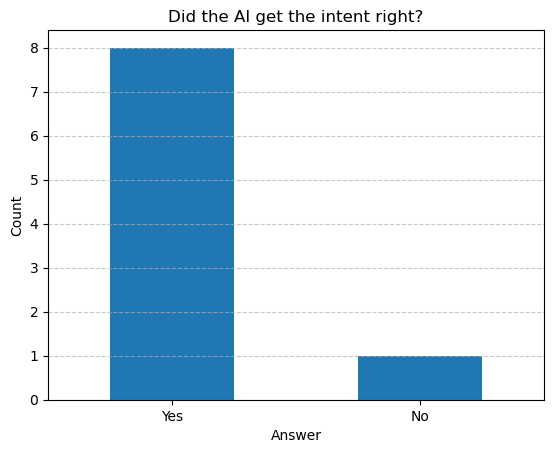

In [175]:
df[df.columns[-1]].value_counts().plot(kind="bar")
print(df[df.columns[-1]].value_counts())

plt.title("Did the AI get the intent right?")
plt.xlabel("Answer")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()